## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler,ConcatDataset, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os

from torch.autograd import Variable
from torchsummary import summary

## Dataset Processing and Visualization

In [2]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(256, 256))
    return image[...,::-1]

### Download data from Kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

##### 1.Real-and-fake-dection dataset
https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection?resource=download

In [11]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection

real-and-fake-face-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q real-and-fake-face-detection.zip -d ./assets

In [13]:
fake = "./assets/real_and_fake_face/training_fake/"
real = "./assets/real_and_fake_face/training_real/"

dataset_raff_fake_path = os.listdir(fake)
dataset_raff_real_path = os.listdir(real)
dataset_raff_path = "./assets/real_and_fake_face/"

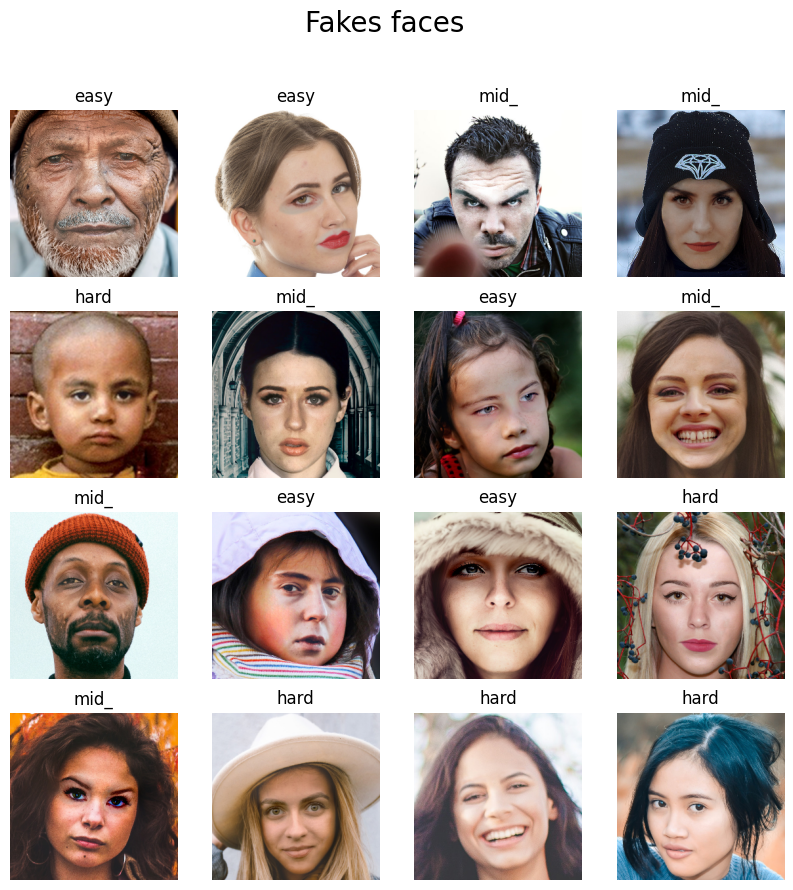

In [14]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + dataset_raff_fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(dataset_raff_fake_path[i][:4])
    plt.axis('off')

plt.show()


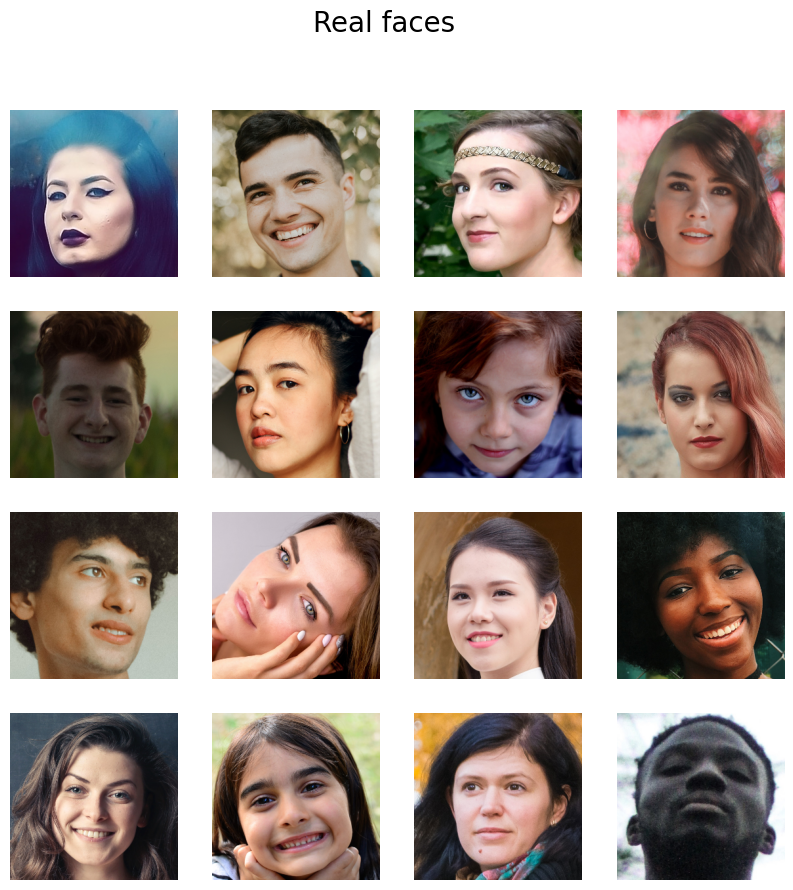

In [15]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + dataset_raff_real_path[i]), cmap='gray')
    plt.suptitle("Real faces", fontsize=20)
    plt.axis('off')

plt.show()

##### 2. Deepfake and real images
https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images/discussion

In [16]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

100% 1.68G/1.68G [00:11<00:00, 243MB/s]
100% 1.68G/1.68G [00:11<00:00, 162MB/s]


In [17]:
!unzip -q deepfake-and-real-images.zip -d ./assets/

In [18]:
dataset_dfari_path = "./assets/Dataset/"
dfari_train_dir = dataset_dfari_path + "Train/"
dfari_test_dir = dataset_dfari_path + "Test/"
dfari_valid_dir = dataset_dfari_path + "Validation/"

target folder ./assets/Dataset/Train//Real
Image shape: (256, 256, 3)


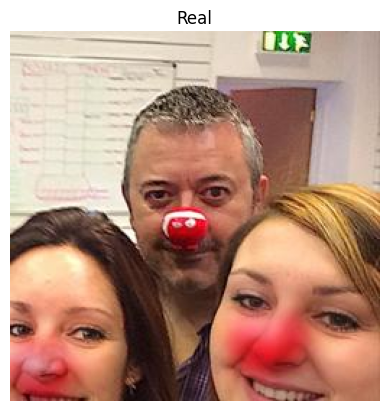

In [19]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  target_folder = target_dir + "/" + target_class
  print(f"target folder {target_folder}")
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

# View random image
img = view_random_image(target_dir=dfari_train_dir,
                        target_class="Real")

## Data processing

#### Dataset Fake and real face detection

In [20]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.Resize((96, 96)),        # Resize images to 96x96
    transforms.ToTensor(),              # Convert images to PyTorch Tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize images
])

dataset_raff_path = datasets.ImageFolder(root=dataset_raff_path, transform=train_transform)

dataset_size = len(dataset_raff_path)
split = int(np.floor(0.2 * dataset_size))
indices = list(range(dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset_raff_path, batch_size=32, sampler=train_sampler)
validation_loader = DataLoader(dataset_raff_path, batch_size=32, sampler=validation_sampler)

print(f"Found {len(train_indices)} images belonging to {len(dataset_raff_path.classes)} classes for training.")
print(f"Found {len(val_indices)} images belonging to {len(dataset_raff_path.classes)} classes for validation.")


Found 1633 images belonging to 2 classes for training.
Found 408 images belonging to 2 classes for validation.


#### Dataset Deep fake and real face iamges

In [69]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.Resize((96, 96)),        # Resize images to 96x96
    transforms.ToTensor(),              # Convert images to PyTorch Tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize images
])

dfari_train_fake_dir = dfari_train_dir + "Fake/"
dfari_train_real_dir = dfari_train_dir + "Real/"

dfari_test_fake_dir = dfari_test_dir + "Fake/"
dfari_test_real_dir = dfari_test_dir + "Real/"

dfari_validation_fake_dir = dfari_valid_dir + "Fake/"
dfari_validation_real_dir = dfari_valid_dir + "Real/"

full_train_dataset_d2 = datasets.ImageFolder(root=dfari_train_dir, transform=train_transform)
full_validation_dataset_d2 = datasets.ImageFolder(root=dfari_valid_dir, transform=train_transform)


train_dataset_size_d2 = int(len(full_train_dataset_d2) / 5)
validation_dataset_size_d2 = int(len(full_validation_dataset_d2) / 5)
train_split_d2 = int(np.floor(0.2 * train_dataset_size_d2))
validation_split_d2 = int(np.floor(0.2 * validation_dataset_size_d2))

num_train_samples = train_dataset_size_d2
num_val_samples = validation_dataset_size_d2

train_indices_d2 = np.random.permutation(len(full_train_dataset_d2))[:num_train_samples]
validation_indices_d2 = np.random.permutation(len(full_validation_dataset_d2))[:num_val_samples]

train_subset = Subset(full_train_dataset_d2, train_indices_d2)
val_subset = Subset(full_validation_dataset_d2, validation_indices_d2)

train_loader_d2 = torch.utils.data.DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
validation_loader_d2 = torch.utils.data.DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

print(f"Found {len(train_indices_d2)} images belonging to {len(full_train_dataset_d2.classes)} classes for training.")
print(f"Found {len(validation_indices_d2)} images belonging to {len(full_validation_dataset_d2.classes)} classes for validation.")

Found 28000 images belonging to 2 classes for training.
Found 7885 images belonging to 2 classes for validation.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model training

In [23]:
def evaluate_model(validation_loader, model, criterion):
    model.eval()  # Make sure the model is in eval mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(validation_loader)
    val_accuracy = correct / total

    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    return val_loss, val_accuracy

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 2)  # Assuming 2 classes: real and fake
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 12 * 12)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.fc2 = nn.Linear(1024, 2)  # Assuming 2 classes: real and fake
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(self.relu(self.conv3(x)))
        x = self.pool(x)
        x = self.bn4(self.relu(self.conv4(x)))
        x = self.pool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class GramBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(GramBlock, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample


    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class GramNet(nn.Module):
    def __init__(self, GramBlock, layers, image_channels, num_classes):
        super(GramNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # GramNet layers
        self.layer1 = self._create_layer(GramBlock, layers[0], out_channels=64, stride=1)
        self.layer2 = self._create_layer(GramBlock, layers[1], out_channels=128, stride=2)
        self.layer3 = self._create_layer(GramBlock, layers[2], out_channels=256, stride=2)
        self.layer4 = self._create_layer(GramBlock, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512 * 4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)  # flatten the output
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def _create_layer(self, GramBlock, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * 4))
        layers.append(GramBlock(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(GramBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

def GramNet51(img_channels=3, num_classes=1000):
    return GramNet(GramBlock, [3, 4, 6, 3], img_channels, num_classes)


# Define Customer MobileNetV2
class CustomizedMobileNetV2(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Load a pre-trained MobileNetV2 model
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        # Replace the classifier with a new one for our face dataset
        self.mobilenet_v2.classifier[1] = nn.Linear(self.mobilenet_v2.last_channel, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

#### Training Method

In [26]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

def train_model(train_loader, validation_loader, model, criterion, optimizer, epochs=20):
    print(device)
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # print(total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)

        val_loss, val_accuracy = evaluate_model(validation_loader, model, criterion)

        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}")

##### Dataset 1, SimpleCNN

In [33]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(train_loader, validation_loader, model, criterion, optimizer)

cuda:0
Validation Loss: 0.6891447901725769, Validation Accuracy: 0.571078431372549
Epoch 1/20 - Loss: 0.7101, Accuracy: 0.51, Val Loss: 0.6891, Val Accuracy: 0.57
Validation Loss: 0.6897763701585623, Validation Accuracy: 0.571078431372549
Epoch 2/20 - Loss: 0.6931, Accuracy: 0.52, Val Loss: 0.6898, Val Accuracy: 0.57
Validation Loss: 0.6898461763675396, Validation Accuracy: 0.571078431372549
Epoch 3/20 - Loss: 0.6919, Accuracy: 0.52, Val Loss: 0.6898, Val Accuracy: 0.57
Validation Loss: 0.6721733441719642, Validation Accuracy: 0.5980392156862745
Epoch 4/20 - Loss: 0.6901, Accuracy: 0.53, Val Loss: 0.6722, Val Accuracy: 0.60
Validation Loss: 0.6776814231505761, Validation Accuracy: 0.5857843137254902
Epoch 5/20 - Loss: 0.6868, Accuracy: 0.54, Val Loss: 0.6777, Val Accuracy: 0.59
Validation Loss: 0.6914866337409387, Validation Accuracy: 0.5294117647058824
Epoch 6/20 - Loss: 0.6845, Accuracy: 0.57, Val Loss: 0.6915, Val Accuracy: 0.53
Validation Loss: 0.6523318932606623, Validation Accura

In [34]:
# model = SimpleCNN().to(device)

summary(model, (3, 96, 96))  # Example for images of size 96x96 with 3 channels (RGB)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
              ReLU-2           [-1, 32, 96, 96]               0
         MaxPool2d-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          18,496
              ReLU-5           [-1, 64, 48, 48]               0
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
              ReLU-8          [-1, 128, 24, 24]               0
         MaxPool2d-9          [-1, 128, 12, 12]               0
           Linear-10                  [-1, 512]       9,437,696
             ReLU-11                  [-1, 512]               0
           Linear-12                    [-1, 2]           1,026
Total params: 9,531,970
Trainable params: 9,531,970
Non-trainable params: 0
---------------------------

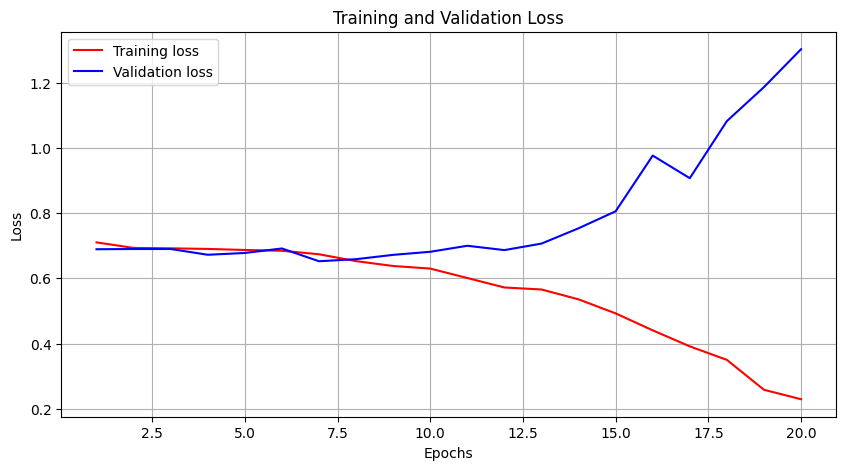

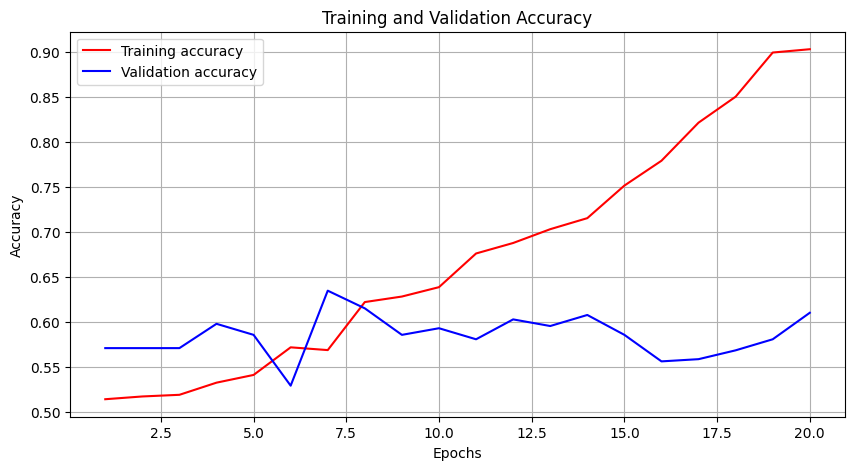

In [35]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]


def plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc):
    """
    Plot the training and validation loss and accuracy.

    Parameters:
    - train_losses: List of training loss values per epoch.
    - val_losses: List of validation loss values per epoch.
    - train_acc: List of training accuracy values per epoch.
    - val_acc: List of validation accuracy values per epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot for loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot for accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc)

#### Dataset 1, ImprovedCNN

In [ ]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(train_loader, validation_loader, model, criterion, optimizer)

Validation Loss: 0.6913101214628953, Validation Accuracy: 0.5637254901960784
Epoch 1/20 - Loss: 1.1502, Accuracy: 0.54%, Val Loss: 0.6913, Val Accuracy: 0.56%
Validation Loss: 0.76166170835495, Validation Accuracy: 0.5441176470588235
Epoch 2/20 - Loss: 0.6843, Accuracy: 0.58%, Val Loss: 0.7617, Val Accuracy: 0.54%
Validation Loss: 0.699920668051793, Validation Accuracy: 0.5441176470588235
Epoch 3/20 - Loss: 0.6702, Accuracy: 0.61%, Val Loss: 0.6999, Val Accuracy: 0.54%
Validation Loss: 0.7007187375655541, Validation Accuracy: 0.5612745098039216
Epoch 4/20 - Loss: 0.6513, Accuracy: 0.61%, Val Loss: 0.7007, Val Accuracy: 0.56%
Validation Loss: 0.6866501798996558, Validation Accuracy: 0.5882352941176471
Epoch 5/20 - Loss: 0.6465, Accuracy: 0.62%, Val Loss: 0.6867, Val Accuracy: 0.59%
Validation Loss: 0.6922498803872329, Validation Accuracy: 0.571078431372549
Epoch 6/20 - Loss: 0.6177, Accuracy: 0.66%, Val Loss: 0.6922, Val Accuracy: 0.57%
Validation Loss: 0.6525230682813205, Validation Ac

In [ ]:
summary(model, (3, 96, 96))  # Example for images of size 96x96 with 3 channels (RGB)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
              ReLU-2           [-1, 32, 96, 96]               0
       BatchNorm2d-3           [-1, 32, 96, 96]              64
         MaxPool2d-4           [-1, 32, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          18,496
              ReLU-6           [-1, 64, 48, 48]               0
       BatchNorm2d-7           [-1, 64, 48, 48]             128
         MaxPool2d-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]          73,856
             ReLU-10          [-1, 128, 24, 24]               0
      BatchNorm2d-11          [-1, 128, 24, 24]             256
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         295,168
             ReLU-14          [-1, 256,

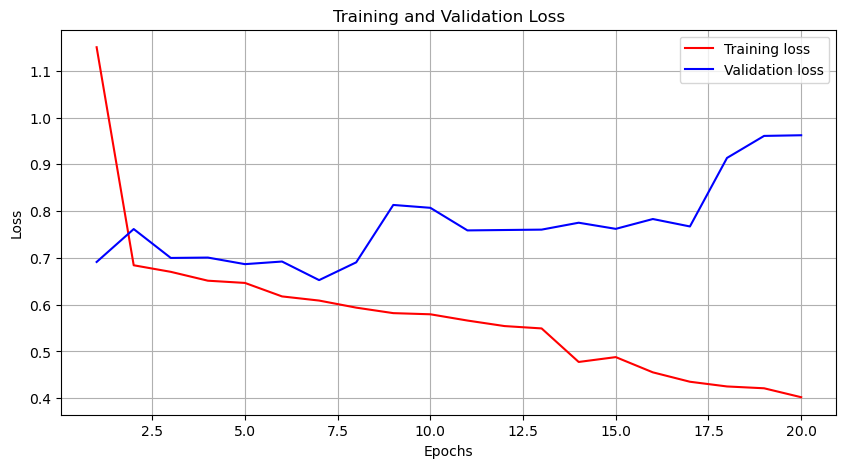

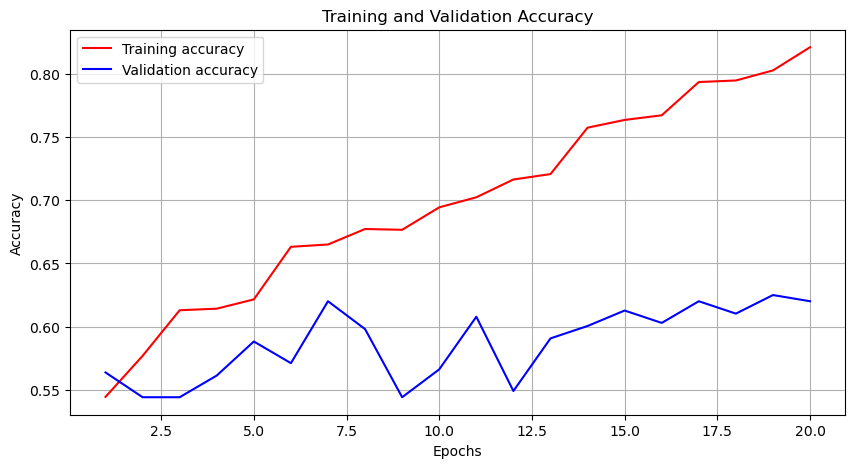

In [ ]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]

plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc)

#### Dataset 1, GramNet51

In [29]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

model = GramNet51().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(train_loader, validation_loader, model, criterion, optimizer)

cuda:0
Validation Loss: 41.63181488330547, Validation Accuracy: 0.571078431372549
Epoch 1/20 - Loss: 1.3787, Accuracy: 0.49, Val Loss: 41.6318, Val Accuracy: 0.57
Validation Loss: 0.9758749237427344, Validation Accuracy: 0.571078431372549
Epoch 2/20 - Loss: 1.0527, Accuracy: 0.51, Val Loss: 0.9759, Val Accuracy: 0.57
Validation Loss: 0.9051111340522766, Validation Accuracy: 0.5784313725490197
Epoch 3/20 - Loss: 0.7772, Accuracy: 0.49, Val Loss: 0.9051, Val Accuracy: 0.58
Validation Loss: 1.176055541405311, Validation Accuracy: 0.42892156862745096
Epoch 4/20 - Loss: 0.8085, Accuracy: 0.50, Val Loss: 1.1761, Val Accuracy: 0.43
Validation Loss: 0.7877980058009808, Validation Accuracy: 0.571078431372549
Epoch 5/20 - Loss: 0.9172, Accuracy: 0.47, Val Loss: 0.7878, Val Accuracy: 0.57
Validation Loss: 0.7122446986345145, Validation Accuracy: 0.47058823529411764
Epoch 6/20 - Loss: 0.7216, Accuracy: 0.50, Val Loss: 0.7122, Val Accuracy: 0.47
Validation Loss: 0.7170106126711919, Validation Accur

In [30]:
summary(model, (3, 96, 96))  # Example for images of size 96x96 with 3 channels (RGB)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,472
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]           4,160
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,928
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]          16,640
      BatchNorm2d-12          [-1, 256, 24, 24]             512
           Conv2d-13          [-1, 256, 24, 24]          16,640
      BatchNorm2d-14          [-1, 256,

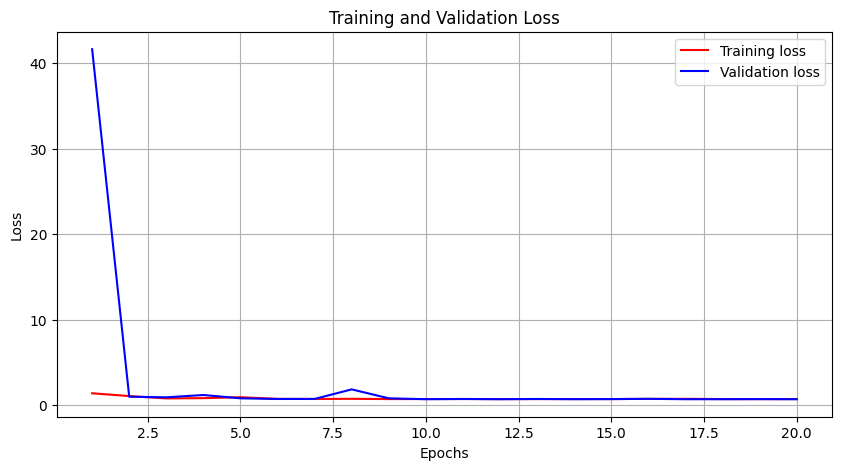

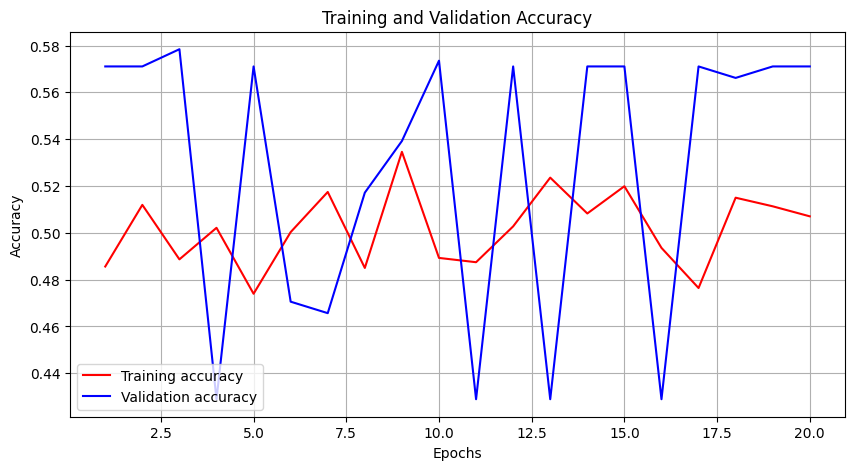

In [32]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]

plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc)

#### Dataset 1, MobileNetV2

In [37]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

model = CustomizedMobileNetV2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(train_loader, validation_loader, model, criterion, optimizer)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 99.7MB/s]


cuda:0
Validation Loss: 0.7442639332551223, Validation Accuracy: 0.6029411764705882
Epoch 1/20 - Loss: 0.7636, Accuracy: 0.58, Val Loss: 0.7443, Val Accuracy: 0.60
Validation Loss: 0.7083683013916016, Validation Accuracy: 0.6495098039215687
Epoch 2/20 - Loss: 0.6156, Accuracy: 0.67, Val Loss: 0.7084, Val Accuracy: 0.65
Validation Loss: 0.7455899646648994, Validation Accuracy: 0.6568627450980392
Epoch 3/20 - Loss: 0.5369, Accuracy: 0.74, Val Loss: 0.7456, Val Accuracy: 0.66
Validation Loss: 0.6993906887678, Validation Accuracy: 0.6740196078431373
Epoch 4/20 - Loss: 0.4884, Accuracy: 0.77, Val Loss: 0.6994, Val Accuracy: 0.67
Validation Loss: 0.7202783249891721, Validation Accuracy: 0.7083333333333334
Epoch 5/20 - Loss: 0.4391, Accuracy: 0.82, Val Loss: 0.7203, Val Accuracy: 0.71
Validation Loss: 0.9807623441402729, Validation Accuracy: 0.5980392156862745
Epoch 6/20 - Loss: 0.4057, Accuracy: 0.83, Val Loss: 0.9808, Val Accuracy: 0.60
Validation Loss: 0.8052318692207336, Validation Accura

In [38]:
summary(model, (3, 96, 96))  # Example for images of size 96x96 with 3 channels (RGB)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
       BatchNorm2d-2           [-1, 32, 48, 48]              64
             ReLU6-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 32, 48, 48]             288
       BatchNorm2d-5           [-1, 32, 48, 48]              64
             ReLU6-6           [-1, 32, 48, 48]               0
            Conv2d-7           [-1, 16, 48, 48]             512
       BatchNorm2d-8           [-1, 16, 48, 48]              32
  InvertedResidual-9           [-1, 16, 48, 48]               0
           Conv2d-10           [-1, 96, 48, 48]           1,536
      BatchNorm2d-11           [-1, 96, 48, 48]             192
            ReLU6-12           [-1, 96, 48, 48]               0
           Conv2d-13           [-1, 96, 24, 24]             864
      BatchNorm2d-14           [-1, 96,

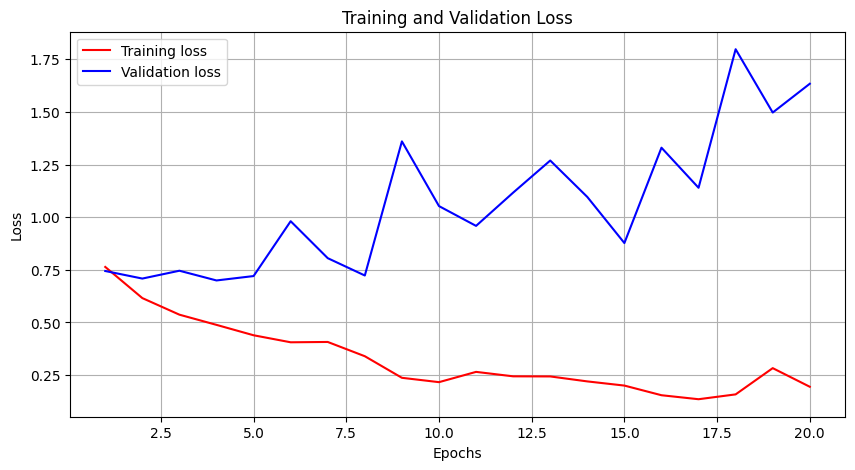

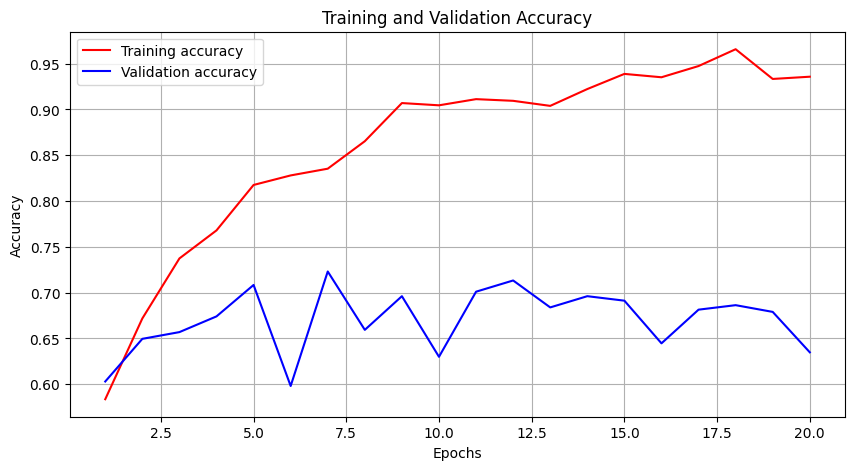

In [39]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]

plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc)

#### Dataset 2, SimpleCNN

In [ ]:
from torch.cuda.amp import GradScaler, autocast

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:0")
train_losses = []
val_losses = []
train_acc = []
val_acc = []
model = []

scaler = GradScaler()

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_model(train_loader_d2, validation_loader_d2, model, criterion, optimizer)

cuda:0
Validation Loss: 0.49478051219231045, Validation Accuracy: 0.7609059551587705
Epoch 1/20 - Loss: 0.5223, Accuracy: 0.73, Val Loss: 0.4948, Val Accuracy: 0.76
Validation Loss: 0.33739568484135163, Validation Accuracy: 0.85211017550979
Epoch 2/20 - Loss: 0.3444, Accuracy: 0.85, Val Loss: 0.3374, Val Accuracy: 0.85
Validation Loss: 0.2809040985810451, Validation Accuracy: 0.8800598559399412
Epoch 3/20 - Loss: 0.2421, Accuracy: 0.90, Val Loss: 0.2809, Val Accuracy: 0.88
Validation Loss: 0.23241031475556204, Validation Accuracy: 0.9023282946129654
Epoch 4/20 - Loss: 0.1918, Accuracy: 0.92, Val Loss: 0.2324, Val Accuracy: 0.90
Validation Loss: 0.2177946028801111, Validation Accuracy: 0.910723343816577
Epoch 5/20 - Loss: 0.1679, Accuracy: 0.93, Val Loss: 0.2178, Val Accuracy: 0.91
Validation Loss: 0.2082656824435943, Validation Accuracy: 0.9156437049812316
Epoch 6/20 - Loss: 0.1524, Accuracy: 0.94, Val Loss: 0.2083, Val Accuracy: 0.92
Validation Loss: 0.2092877664627173, Validation Acc

In [ ]:
summary(model, (3, 96, 96))  # Example for images of size 96x96 with 3 channels (RGB)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
              ReLU-2           [-1, 32, 96, 96]               0
         MaxPool2d-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          18,496
              ReLU-5           [-1, 64, 48, 48]               0
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
              ReLU-8          [-1, 128, 24, 24]               0
         MaxPool2d-9          [-1, 128, 12, 12]               0
           Linear-10                  [-1, 512]       9,437,696
             ReLU-11                  [-1, 512]               0
           Linear-12                    [-1, 2]           1,026
Total params: 9,531,970
Trainable params: 9,531,970
Non-trainable params: 0
---------------------------

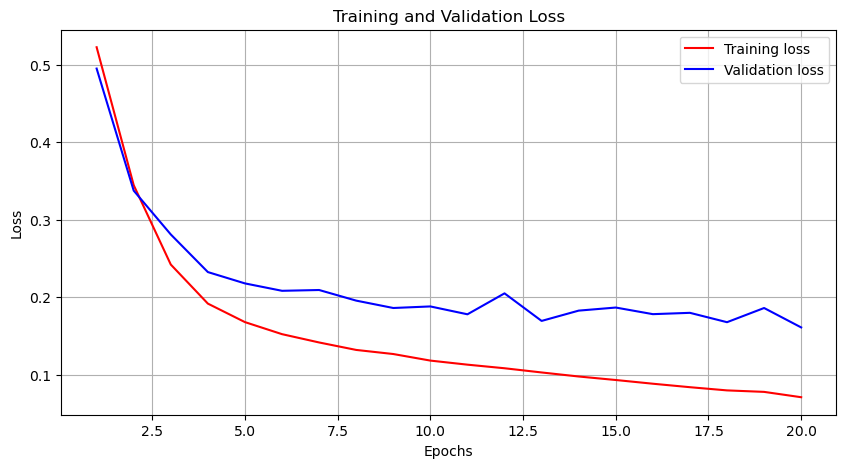

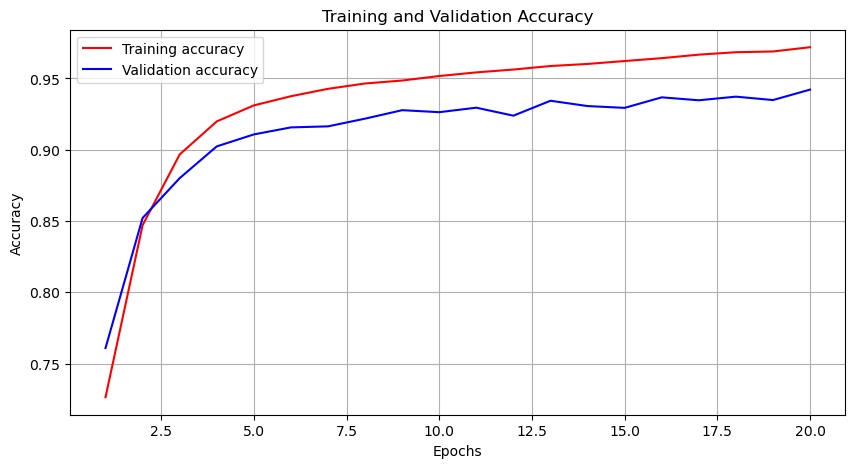

In [ ]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]

plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc)

#### Dataset 2, ImprovedCNN

In [ ]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(train_loader_d2, validation_loader_d2, model, criterion, optimizer)

cuda:0
Validation Loss: 0.46208967306675053, Validation Accuracy: 0.7804605863853099
Epoch 1/20 - Loss: 0.7017, Accuracy: 0.70, Val Loss: 0.4621, Val Accuracy: 0.78
Validation Loss: 0.24929314928177077, Validation Accuracy: 0.8919295931825099
Epoch 2/20 - Loss: 0.2784, Accuracy: 0.88, Val Loss: 0.2493, Val Accuracy: 0.89
Validation Loss: 0.19220113907104883, Validation Accuracy: 0.9220351019579994
Epoch 3/20 - Loss: 0.1561, Accuracy: 0.94, Val Loss: 0.1922, Val Accuracy: 0.92
Validation Loss: 0.21357974868554336, Validation Accuracy: 0.913310337830983
Epoch 4/20 - Loss: 0.1227, Accuracy: 0.95, Val Loss: 0.2136, Val Accuracy: 0.91
Validation Loss: 0.16077900391358596, Validation Accuracy: 0.9373034391802779
Epoch 5/20 - Loss: 0.1042, Accuracy: 0.96, Val Loss: 0.1608, Val Accuracy: 0.94
Validation Loss: 0.14524121563404035, Validation Accuracy: 0.9452165973419905
Epoch 6/20 - Loss: 0.0918, Accuracy: 0.96, Val Loss: 0.1452, Val Accuracy: 0.95
Validation Loss: 0.14020436123395577, Validati

In [ ]:
torch.save(model, 'model_improvedcnn_d2_complete.pth')

In [ ]:
summary(model, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
              ReLU-2           [-1, 32, 96, 96]               0
       BatchNorm2d-3           [-1, 32, 96, 96]              64
         MaxPool2d-4           [-1, 32, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          18,496
              ReLU-6           [-1, 64, 48, 48]               0
       BatchNorm2d-7           [-1, 64, 48, 48]             128
         MaxPool2d-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]          73,856
             ReLU-10          [-1, 128, 24, 24]               0
      BatchNorm2d-11          [-1, 128, 24, 24]             256
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         295,168
             ReLU-14          [-1, 256,

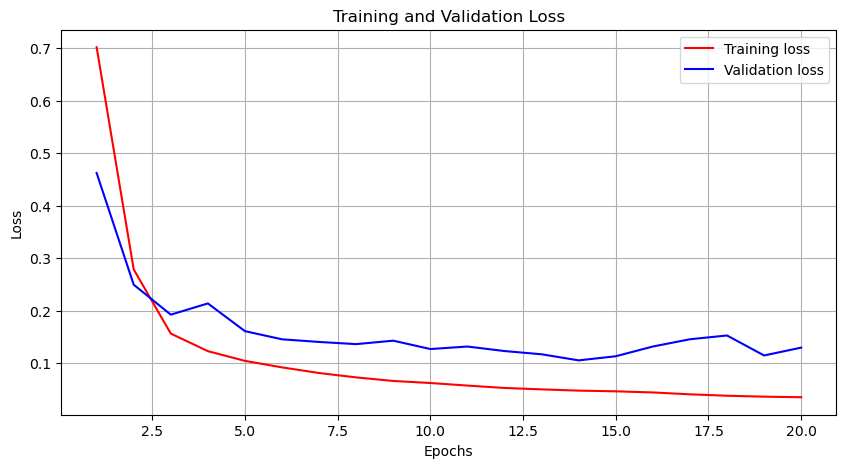

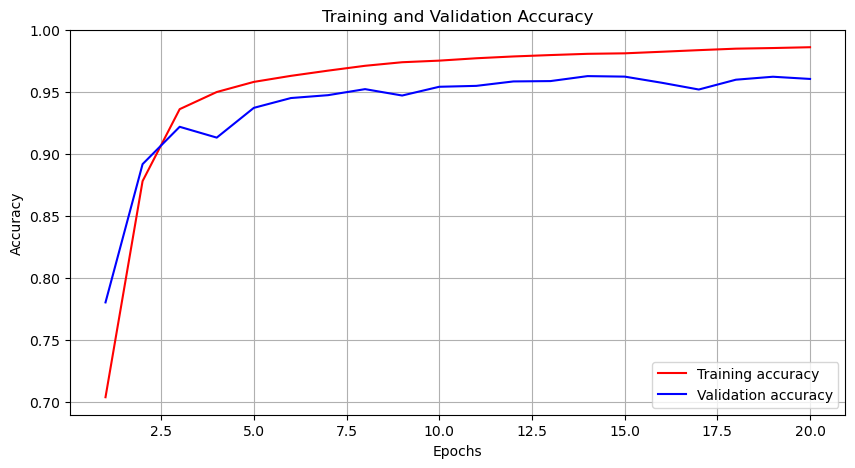

In [ ]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]

plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc)

#### Dataset 2, GramNet51

In [59]:
torch.cuda.empty_cache()  # Clear unused memory

In [70]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = GramNet51().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(train_loader_d2, validation_loader_d2, model, criterion, optimizer)
torch.save(model, 'model_gramnet51_d2_complete.pth')

cuda:0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5561130142981007, Validation Accuracy: 0.727710843373494
Epoch 1/20 - Loss: 0.8488, Accuracy: 0.61, Val Loss: 0.5561, Val Accuracy: 0.73
Validation Loss: 0.5088500668925624, Validation Accuracy: 0.7507926442612556
Epoch 2/20 - Loss: 0.4502, Accuracy: 0.79, Val Loss: 0.5089, Val Accuracy: 0.75
Validation Loss: 0.390007552600676, Validation Accuracy: 0.8173747622067217
Epoch 3/20 - Loss: 0.3335, Accuracy: 0.85, Val Loss: 0.3900, Val Accuracy: 0.82
Validation Loss: 0.42303783662857547, Validation Accuracy: 0.8295497780596068
Epoch 4/20 - Loss: 0.2621, Accuracy: 0.89, Val Loss: 0.4230, Val Accuracy: 0.83
Validation Loss: 0.31716801562616903, Validation Accuracy: 0.8758402029169309
Epoch 5/20 - Loss: 0.2140, Accuracy: 0.91, Val Loss: 0.3172, Val Accuracy: 0.88
Validation Loss: 0.2651917833474375, Validation Accuracy: 0.8919467343056436
Epoch 6/20 - Loss: 0.1797, Accuracy: 0.93, Val Loss: 0.2652, Val Accuracy: 0.89
Validation Loss: 0.267865686166671, Validation Accuracy: 0

In [ ]:
summary(model, (3, 96, 96))

In [ ]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]

plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc)

#### Dataset 2, MobileNetV2

In [61]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

model = CustomizedMobileNetV2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(train_loader_d2, validation_loader_d2, model, criterion, optimizer)
torch.save(model, 'model_mobilenetv2_d2_complete.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0
Validation Loss: 0.10344430445449336, Validation Accuracy: 0.9558942883230191
Epoch 1/20 - Loss: 0.1135, Accuracy: 0.95, Val Loss: 0.1034, Val Accuracy: 0.96
Validation Loss: 0.11883126535066103, Validation Accuracy: 0.9545754286294005
Epoch 2/20 - Loss: 0.0668, Accuracy: 0.97, Val Loss: 0.1188, Val Accuracy: 0.95
Validation Loss: 0.0943648225456972, Validation Accuracy: 0.9666227046768794
Epoch 3/20 - Loss: 0.0545, Accuracy: 0.98, Val Loss: 0.0944, Val Accuracy: 0.97
Validation Loss: 0.12629306714473887, Validation Accuracy: 0.9561225525007608
Epoch 4/20 - Loss: 0.0503, Accuracy: 0.98, Val Loss: 0.1263, Val Accuracy: 0.96
Validation Loss: 0.11742533781624286, Validation Accuracy: 0.9557674748909405
Epoch 5/20 - Loss: 0.0472, Accuracy: 0.98, Val Loss: 0.1174, Val Accuracy: 0.96
Validation Loss: 0.08078609067020044, Validation Accuracy: 0.9680937404889925
Epoch 6/20 - Loss: 0.0416, Accuracy: 0.98, Val Loss: 0.0808, Val Accuracy: 0.97
Validation Loss: 0.08472759011936197, Validati

In [62]:
summary(model, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
       BatchNorm2d-2           [-1, 32, 48, 48]              64
             ReLU6-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 32, 48, 48]             288
       BatchNorm2d-5           [-1, 32, 48, 48]              64
             ReLU6-6           [-1, 32, 48, 48]               0
            Conv2d-7           [-1, 16, 48, 48]             512
       BatchNorm2d-8           [-1, 16, 48, 48]              32
  InvertedResidual-9           [-1, 16, 48, 48]               0
           Conv2d-10           [-1, 96, 48, 48]           1,536
      BatchNorm2d-11           [-1, 96, 48, 48]             192
            ReLU6-12           [-1, 96, 48, 48]               0
           Conv2d-13           [-1, 96, 24, 24]             864
      BatchNorm2d-14           [-1, 96,

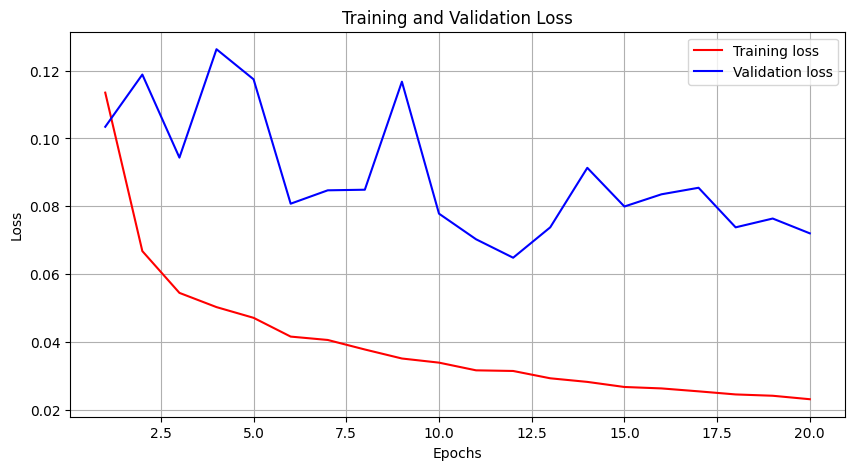

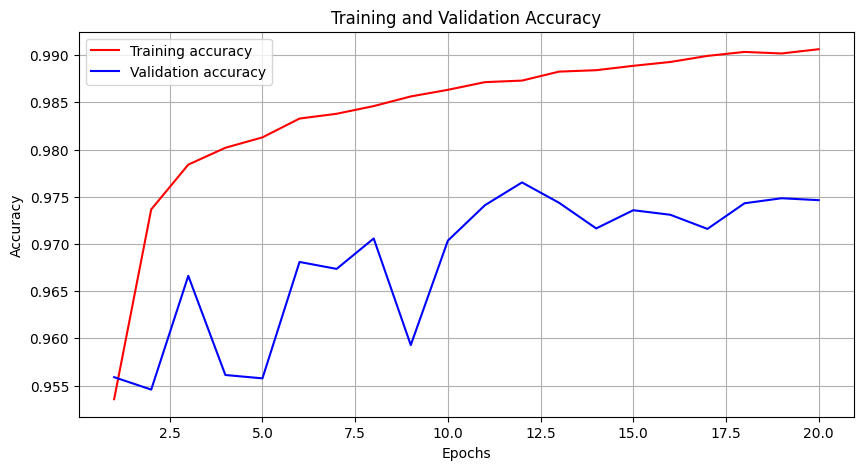

In [63]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]

plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc)

## Cross-dataset training

#### Data Processing

In [71]:
train_transform_cd = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [72]:
# Dataset 1
dataset_raff_cd = datasets.ImageFolder(root="./assets/real_and_fake_face/", transform=train_transform_cd)

# Dataset 2
dfari_train_cd = datasets.ImageFolder(root=dfari_train_dir, transform=train_transform_cd)
dfari_valid_cd = datasets.ImageFolder(root=dfari_valid_dir, transform=train_transform_cd)

In [88]:
dataset_size_cd = len(dataset_raff_cd)
split_cd = int(np.floor(0.2 * dataset_size_cd))
indices_cd = torch.randperm(dataset_size_cd).tolist()

train_indices_cd = indices_cd[split:]
val_indices_cd = indices_cd[:split]

train_subset_cd = Subset(dataset_raff_cd, train_indices_cd)
val_subset_cd = Subset(dataset_raff_cd, val_indices_cd)

# Calculate the number of samples for 1/5th of the dataset
num_train_samples = int(len(dfari_train_cd) / 5)
num_validation_samples = int(len(dfari_valid_cd) / 5)

# Generate random indices for train and validation datasets
train_indices = torch.randperm(int(len(dfari_train_cd) / 5))[:num_train_samples]
validation_indices = torch.randperm(int(len(dfari_valid_cd) / 5))[:num_validation_samples]

# Create subsets containing 1/5th of the datasets
dfari_train_cd = Subset(dfari_train_cd, train_indices)
dfari_valid_cd = Subset(dfari_valid_cd, validation_indices)

In [89]:
# Merge training set
train_dataset_cd = ConcatDataset([train_subset_cd, dfari_train_cd])

# Merge validation set
validation_dataset_cd = ConcatDataset([val_subset_cd, dfari_valid_cd])

In [90]:
batch_size_cd = 256

train_loader_cd = DataLoader(train_dataset_cd, batch_size=batch_size_cd, shuffle=True, num_workers=4, pin_memory=True)

validation_loader_cd = DataLoader(validation_dataset_cd, batch_size=batch_size_cd, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [98]:
# Calculate total number of images in each dataset
total_train_images = len(train_dataset_cd)
total_validation_images = len(validation_dataset_cd)

print(f"Found {total_train_images} images for training across {len(dfari_train_cd.dataset.classes)} classes.")
print(f"Found {total_validation_images} images for validation across {len(dfari_valid_cd.dataset.classes)} classes.")

Found 29633 images for training across 2 classes.
Found 8293 images for validation across 2 classes.


#### Train model

#### Cross-dataset, ImprovedCNN

In [ ]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

model_cd = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(train_loader_cd, validation_loader_cd, model_cd, criterion, optimizer)

cuda:0
Validation Loss: 0.7072489750690949, Validation Accuracy: 0.5149111356561904
Epoch 1/20 - Loss: 0.7171, Accuracy: 0.52, Val Loss: 0.7072, Val Accuracy: 0.51
Validation Loss: 0.7080020155662146, Validation Accuracy: 0.5126267697559996
Epoch 2/20 - Loss: 0.7174, Accuracy: 0.52, Val Loss: 0.7080, Val Accuracy: 0.51
Validation Loss: 0.7080603532302074, Validation Accuracy: 0.5130786223516417
Epoch 3/20 - Loss: 0.7176, Accuracy: 0.52, Val Loss: 0.7081, Val Accuracy: 0.51
Validation Loss: 0.7066813432253324, Validation Accuracy: 0.5180238979817251
Epoch 4/20 - Loss: 0.7178, Accuracy: 0.52, Val Loss: 0.7067, Val Accuracy: 0.52
Validation Loss: 0.7081890916213011, Validation Accuracy: 0.512501255146099
Epoch 5/20 - Loss: 0.7179, Accuracy: 0.52, Val Loss: 0.7082, Val Accuracy: 0.51
Validation Loss: 0.707637641674433, Validation Accuracy: 0.51483582689025
Epoch 6/20 - Loss: 0.7194, Accuracy: 0.51, Val Loss: 0.7076, Val Accuracy: 0.51
Validation Loss: 0.7071830722001883, Validation Accurac

In [ ]:
torch.save(model_cd, 'model_improvedcnn_cd_complete_20epochs.pth')

In [ ]:
summary(model, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
              ReLU-2           [-1, 32, 96, 96]               0
       BatchNorm2d-3           [-1, 32, 96, 96]              64
         MaxPool2d-4           [-1, 32, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          18,496
              ReLU-6           [-1, 64, 48, 48]               0
       BatchNorm2d-7           [-1, 64, 48, 48]             128
         MaxPool2d-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]          73,856
             ReLU-10          [-1, 128, 24, 24]               0
      BatchNorm2d-11          [-1, 128, 24, 24]             256
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         295,168
             ReLU-14          [-1, 256,

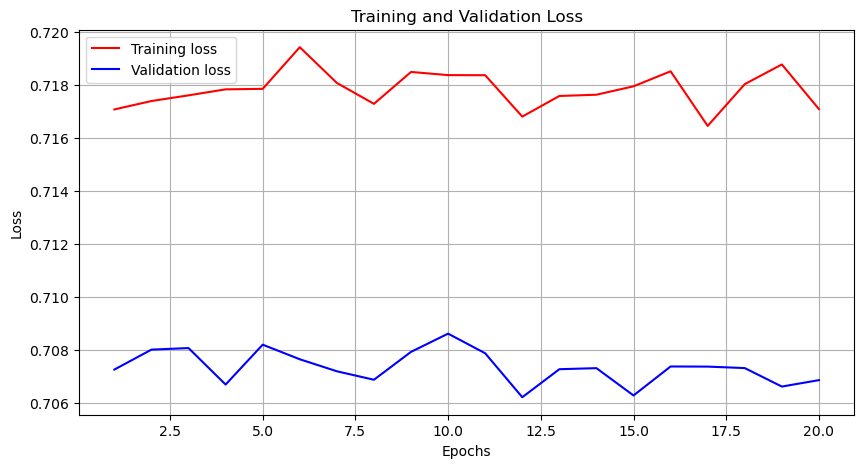

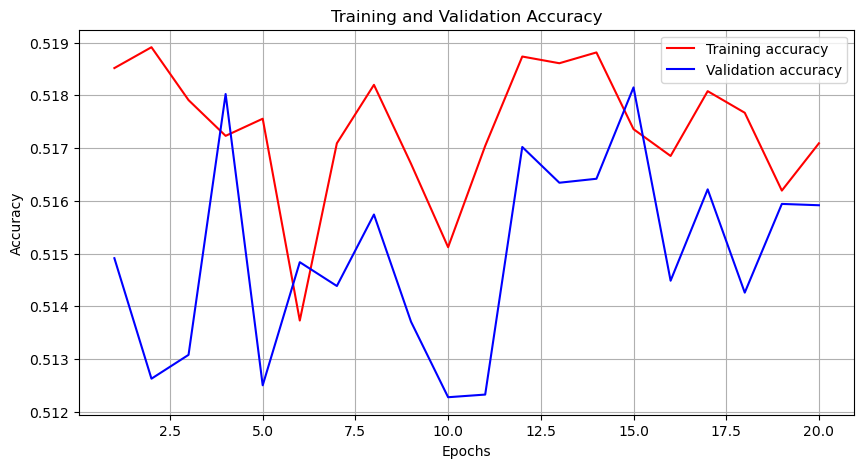

In [ ]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]

plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc)

#### Cross-dataset, GramNet51

In [100]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

model = GramNet51().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(train_loader_cd, validation_loader_cd, model, criterion, optimizer)
torch.save(model, 'model_gramnet51_crossdataset_complete.pth')

cuda:0
Validation Loss: 0.14165469352155924, Validation Accuracy: 0.9722657663089352
Epoch 1/20 - Loss: 0.2603, Accuracy: 0.96, Val Loss: 0.1417, Val Accuracy: 0.97
Validation Loss: 0.0917215829884464, Validation Accuracy: 0.9722657663089352
Epoch 2/20 - Loss: 0.1437, Accuracy: 0.97, Val Loss: 0.0917, Val Accuracy: 0.97
Validation Loss: 0.0765639708349199, Validation Accuracy: 0.9716628481852164
Epoch 3/20 - Loss: 0.0794, Accuracy: 0.97, Val Loss: 0.0766, Val Accuracy: 0.97
Validation Loss: 0.07367648816469943, Validation Accuracy: 0.9722657663089352
Epoch 4/20 - Loss: 0.0706, Accuracy: 0.97, Val Loss: 0.0737, Val Accuracy: 0.97
Validation Loss: 0.06407122206733082, Validation Accuracy: 0.9726275171831665
Epoch 5/20 - Loss: 0.0636, Accuracy: 0.97, Val Loss: 0.0641, Val Accuracy: 0.97
Validation Loss: 0.05557991938213959, Validation Accuracy: 0.9749186060532979
Epoch 6/20 - Loss: 0.0569, Accuracy: 0.97, Val Loss: 0.0556, Val Accuracy: 0.97
Validation Loss: 0.05401705683096114, Validatio

In [101]:
summary(model, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,472
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]           4,160
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,928
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]          16,640
      BatchNorm2d-12          [-1, 256, 24, 24]             512
           Conv2d-13          [-1, 256, 24, 24]          16,640
      BatchNorm2d-14          [-1, 256,

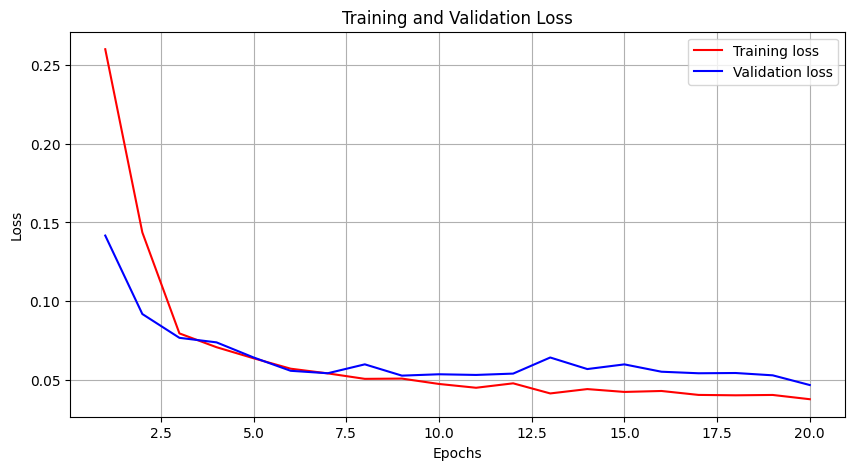

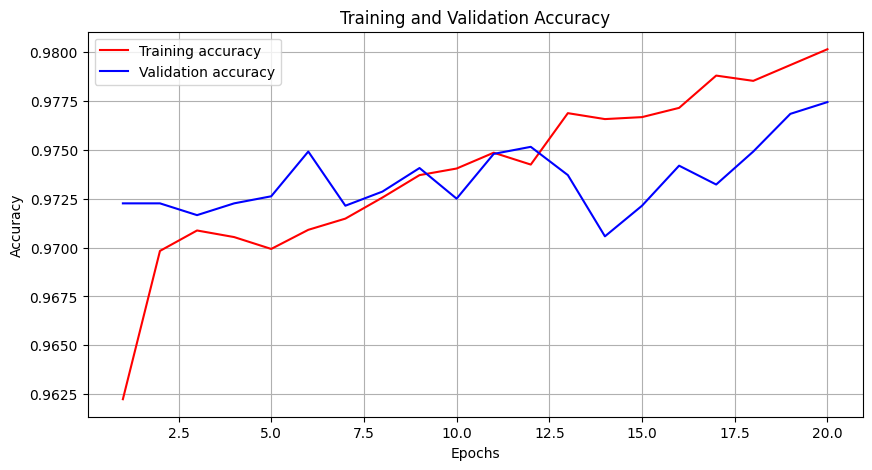

In [102]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]

plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc)

#### Cross-dataset, MobileNetV2

In [103]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

model = CustomizedMobileNetV2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(train_loader_cd, validation_loader_cd, model, criterion, optimizer)
torch.save(model, 'model_mobilenetv2_crossdataset_complete.pth')

cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Loss: 0.03963692278149679, Validation Accuracy: 0.9760038586759918
Epoch 1/20 - Loss: 0.0533, Accuracy: 0.97, Val Loss: 0.0396, Val Accuracy: 0.98
Validation Loss: 0.04033095210660108, Validation Accuracy: 0.9761244423007356
Epoch 2/20 - Loss: 0.0404, Accuracy: 0.98, Val Loss: 0.0403, Val Accuracy: 0.98
Validation Loss: 0.038930516855819434, Validation Accuracy: 0.9758832750512481
Epoch 3/20 - Loss: 0.0364, Accuracy: 0.98, Val Loss: 0.0389, Val Accuracy: 0.98
Validation Loss: 0.04105073530456249, Validation Accuracy: 0.9772096949234294
Epoch 4/20 - Loss: 0.0323, Accuracy: 0.98, Val Loss: 0.0411, Val Accuracy: 0.98
Validation Loss: 0.04669224123018935, Validation Accuracy: 0.9749186060532979
Epoch 5/20 - Loss: 0.0330, Accuracy: 0.98, Val Loss: 0.0467, Val Accuracy: 0.97
Validation Loss: 0.04626012955453585, Validation Accuracy: 0.9758832750512481
Epoch 6/20 - Loss: 0.0297, Accuracy: 0.99, Val Loss: 0.0463, Val Accuracy: 0.98
Validation Loss: 0.0602636416513247, Validation Acc

In [104]:
summary(model, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
       BatchNorm2d-2           [-1, 32, 48, 48]              64
             ReLU6-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 32, 48, 48]             288
       BatchNorm2d-5           [-1, 32, 48, 48]              64
             ReLU6-6           [-1, 32, 48, 48]               0
            Conv2d-7           [-1, 16, 48, 48]             512
       BatchNorm2d-8           [-1, 16, 48, 48]              32
  InvertedResidual-9           [-1, 16, 48, 48]               0
           Conv2d-10           [-1, 96, 48, 48]           1,536
      BatchNorm2d-11           [-1, 96, 48, 48]             192
            ReLU6-12           [-1, 96, 48, 48]               0
           Conv2d-13           [-1, 96, 24, 24]             864
      BatchNorm2d-14           [-1, 96,

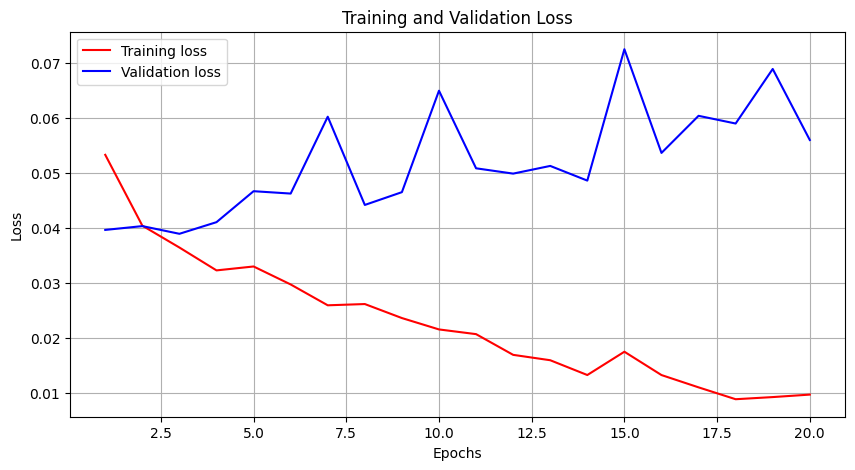

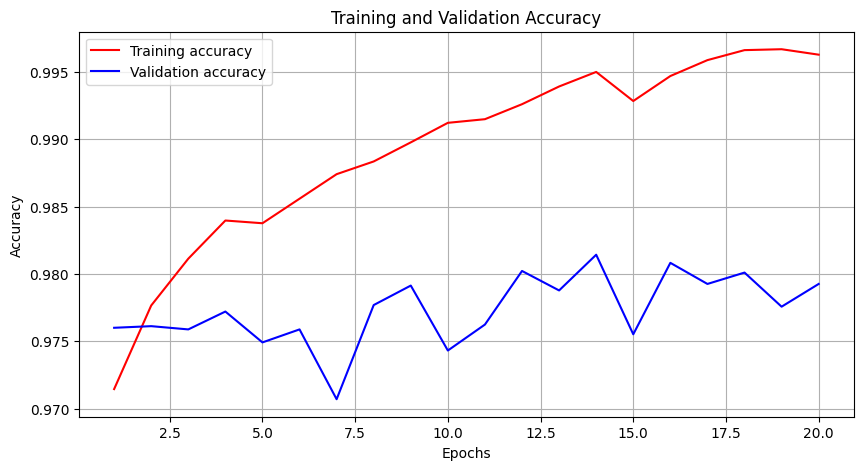

In [105]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]

plot_loss_and_accuracy(train_losses, val_losses, train_acc, val_acc)